# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from datetime import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from scipy.spatial.transform import Rotation as R
from sklearn.linear_model import LinearRegression

from utils import *
from grace.utils import *

# Initialization

## Helper Functions

In [2]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#7fff00', '#d2b48c', '#000080']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
        corners = corners.squeeze()
    else:
        corners = None
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    if corners is not None:
        int_corners = np.round(corners).astype(int)

        depth_list = []
        for corner in int_corners:
            depth_list.append(depth_img[corner[1], corner[0]])
        depth_list = np.array(depth_list)
        depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0

        fx = camera_mtx[0][0]
        cx = camera_mtx[0][2]
        fy = camera_mtx[1][1]
        cy = camera_mtx[1][2]

        obj_pts = []
        for i,(u,v) in enumerate(corners):
            z = depth_list[i]/1000.0
            if z<=0:
                z = depth_mean
            z = z - 0.0042  # Added realsense discrepancy
            x = ((u-cx)/fx)*z
            y = ((v-cy)/fy)*z
            obj_pts.append([x, y, z])
        obj_pts = np.array(obj_pts)
    else:
        obj_pts = None
        
    return obj_pts

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    if corners is not None:
        # Estimate the extrinsic matrix
        # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
        retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
        # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)

        # Convert the rotation vector to a rotation matrix
        rotation_matrix, _ = cv2.Rodrigues(rvec)

        # Homogeneous Coordinates
        H = np.eye(4)
        H[:3,:3] = rotation_matrix
        H[:3,-1] = tvec.T

        # Camera Pose
        T = np.linalg.inv(H)
    else:
        T = None
    
    return T

def get_rmse_pose(T, img, obj_pts, camera_mtx, dist_coef):
    if T is not None:
        T = np.linalg.inv(T)  # Input T is T_board_to_any
        corners = get_chess_corners(img, camera_mtx, dist_coef)

        rvec,_ = cv2.Rodrigues(T[:3,:3])
        tvec = T[:3,-1].reshape(-1,1)

        # Project the 3D points onto the image plane
        projected_points, _ = cv2.projectPoints(obj_pts, rvec, tvec, camera_mtx, dist_coef)

        # Calculate the RMSE
        error = np.sqrt(np.mean(np.square(corners - projected_points.squeeze())))
    else:
        error = 1000
    return error
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    z = z - 0.0042  # Added realsense discrepancy
    if z<=0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

def transform_points(pts, T_mtx):
    new_obj_pts = []
    for pt in pts:
        temp_pt = np.append(pt, 1).reshape(-1,1)
        temp_pt2 = (T_mtx @ temp_pt).squeeze()
        new_obj_pts.append(temp_pt2[:3])
    new_obj_pts = np.array(new_obj_pts)
    return new_obj_pts

def chest_rgb_to_eye(T_chest, T_input):
    T_chest_inv = np.linalg.inv(T_chest)  # T_cb = T_bc^(-1)
    T_final = np.matmul(T_chest_inv, T_input)  # T_cl = T_cb x T_bl
    return T_final

# Loading of Data

## Pickle Data

In [3]:
filename = 'pantilt_baseline_sweep_pickle_20240410_143539_697852.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'pantilt_baseline_sweep',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



In [6]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_left_pan_cmd'][:-2].tolist() 
pickle_df['theta_right_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_right_pan_cmd'][:-2].tolist() 
pickle_df['theta_tilt_cmd_tminus2'] = [0,0] + pickle_df['theta_tilt_cmd'][:-2].tolist()
pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()
pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [7]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [8]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_left_pan_cmd_tminus2',
       'theta_right_pan_cmd_tminus2', 'theta_tilt_cmd_tminus2',
       'theta_left_pan_cmd_tminus1', 'theta_right_pan_cmd_tminus1',
       'theta_tilt_cmd_tminus1', 'chess_idx_tminus1', 'theta_left_pan_tminus1',
       't

In [9]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,2)).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.351562,-12.392578,0.263672,390.354614,108.679115,351.887115,222.992477,382.857941,234.857086,...,21.796875,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
1,6,-16.962891,-17.138672,21.884766,447.884735,107.143616,-360.600000,-224.700000,-222.300000,-235.900000,...,0.263672,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
2,8,0.615234,-11.337891,0.263672,505.842468,105.293259,450.364807,224.170441,481.181549,238.567886,...,21.884766,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
3,6,-16.875000,-17.138672,21.884766,564.532227,103.452454,-360.600000,-224.700000,-222.300000,-235.900000,...,0.263672,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
4,4,1.582031,-10.371094,0.263672,505.791687,105.291992,433.394867,223.948380,459.217834,238.182587,...,21.884766,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3


# 1st Filtering: Remove Reset Command

In [10]:
filt_df = pickle_df[(pickle_df['theta_left_pan_cmd_tminus1']>-13) & (pickle_df['theta_left_pan_cmd_tminus1']<13) ].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.351562,-12.392578,0.263672,390.354614,108.679115,351.887115,222.992477,382.857941,234.857086,...,21.796875,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
1,8,0.615234,-11.337891,0.263672,505.842468,105.293259,450.364807,224.170441,481.181549,238.567886,...,21.884766,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
2,4,1.582031,-10.371094,0.263672,505.791687,105.291992,433.394867,223.948380,459.217834,238.182587,...,21.884766,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
3,0,2.636719,-9.404297,0.263672,390.364197,108.657776,304.922272,222.327454,327.112488,233.802032,...,21.972656,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
4,4,3.515625,-8.437500,0.263672,390.328552,108.646935,290.084869,222.138550,310.280884,233.553864,...,21.884766,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3


In [11]:
print(filt_df['theta_left_pan_cmd_tminus1'].unique())
print(filt_df['theta_right_pan_cmd_tminus1'].unique())
print(filt_df['theta_tilt_cmd_tminus1'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]
[  0  -5 -10 -15 -20 -25 -30]


# Chest Corners Detection and Transformation

In [12]:
# Example

chest_img = filt_df['chest_img'][0]
depth_img = filt_df['depth_img'][0]

In [13]:
# Get Chess Corners

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)

In [14]:
# Define the 3D coordinates of the chessboard corners in the world coordinate system
chessboard_size = (9, 6)
origin_point = [0,0]
square_size = 0.0467  # Assumiimgng each square size is 1 unit
obj_pts = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
obj_pts[:,:2] = (np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) -np.array(origin_point))* square_size

(300.0, 40.0)

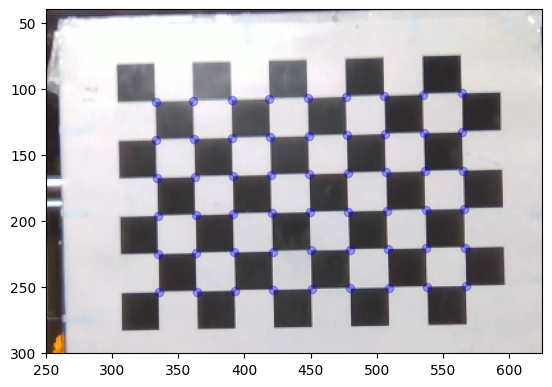

In [15]:
plt.figure()
plt.imshow(chest_img)
for u,v in corners:
    plt.scatter(u,v, color='blue',alpha=0.3)
plt.xlim([250, 625])
plt.ylim([300, 40])

In [16]:
# Transformation for the shifting of the center

T_chest_cam_ctr = np.eye(4)
T_chest_cam_ctr[0, -1] = -0.0325  # chest rgb to module center, 32.5 mm
T_chest_cam_ctr

array([[ 1.    ,  0.    ,  0.    , -0.0325],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [17]:
# Transformation: Board to Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

# 2nd Filtering: RMSE and Motion Blur

## Left Eye

In [18]:
# Board to Left Eye Camera

img_left_list = filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_left_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))
filt_df['T_bl'] = T_left_list

In [19]:
rmse_left_list = []
for i in range(len(T_left_list)):
    T = T_left_list[i]
    img = img_left_list[i]
    rmse_left_list.append(get_rmse_pose(T, img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))
filt_df['rmse_left'] = rmse_left_list

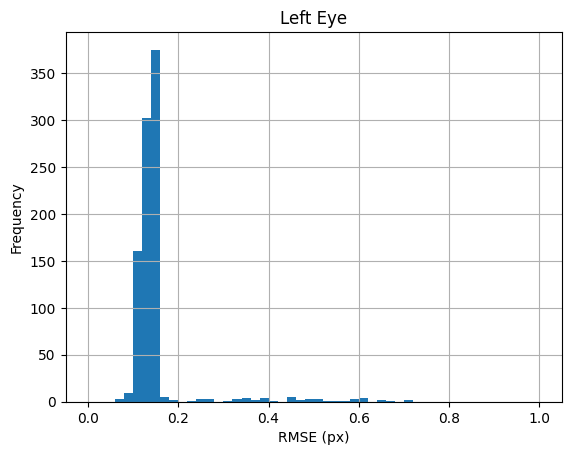

In [20]:
# Before Thresholding

plt.figure()
plt.hist(rmse_left_list, range=(0,1), bins=50)
plt.xlabel('RMSE (px)')
plt.ylabel('Frequency')
plt.title('Left Eye')
plt.grid()

In [21]:
# Remove Bad Batch

filt_df = filt_df.drop(filt_df[filt_df['rmse_left'] > 0.2].index).reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt,T_bl,rmse_left
0,4,-0.351562,-12.392578,0.263672,390.354614,108.679115,351.887115,222.992477,382.857941,234.857086,...,0.0,0.0,0.0,0.0,0.0,3,3,3,"[[0.9832723454951731, 0.0098478441549263, -0.1...",0.147716
1,8,0.615234,-11.337891,0.263672,505.842468,105.293259,450.364807,224.170441,481.181549,238.567886,...,0.0,0.0,0.0,0.0,0.0,3,3,3,"[[0.987752175705732, 0.010183411401979332, -0....",0.135496
2,4,1.582031,-10.371094,0.263672,505.791687,105.291992,433.394867,223.948380,459.217834,238.182587,...,0.0,0.0,0.0,0.0,0.0,3,3,3,"[[0.9918473125966244, 0.01080183104160382, -0....",0.130370
3,0,2.636719,-9.404297,0.263672,390.364197,108.657776,304.922272,222.327454,327.112488,233.802032,...,0.0,0.0,0.0,0.0,0.0,3,3,3,"[[0.9954400548382892, 0.011453115464604853, -0...",0.133828
4,4,3.515625,-8.437500,0.263672,390.328552,108.646935,290.084869,222.138550,310.280884,233.553864,...,0.0,0.0,0.0,0.0,0.0,3,3,3,"[[0.9977108622759886, 0.012088447062678923, -0...",0.138633


## Right Eye

In [22]:
img_right_list = filt_df['right_eye_img'].tolist()
T_right_list = []
for img in img_right_list:
    T_right_list.append(get_camera_pose(img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))
filt_df['T_br'] = T_right_list

In [23]:
rmse_right_list = []
for i in range(len(T_right_list)):
    T = T_right_list[i]
    img = img_right_list[i]
    rmse_right_list.append(get_rmse_pose(T, img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))
filt_df['rmse_right'] = rmse_right_list

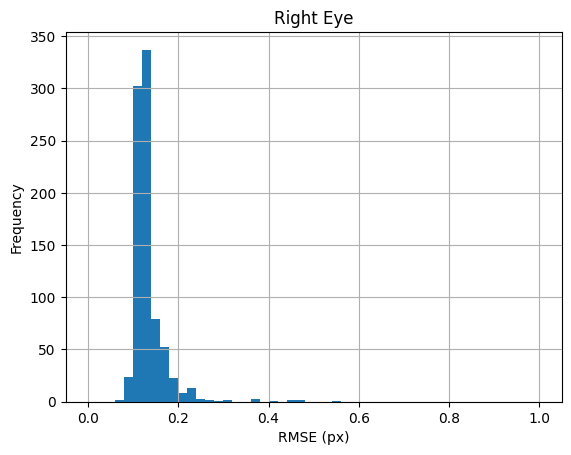

In [24]:
plt.figure()
plt.hist(rmse_right_list, range=(0,1), bins=50)
plt.xlabel('RMSE (px)')
plt.ylabel('Frequency')
plt.title('Right Eye')
plt.grid()

In [25]:
# Remove Bad Batch

filt_df = filt_df.drop(filt_df[filt_df['rmse_right'] > 0.3].index).reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt,T_bl,rmse_left,T_br,rmse_right
0,4,-0.351562,-12.392578,0.263672,390.354614,108.679115,351.887115,222.992477,382.857941,234.857086,...,0.0,0.0,0.0,3,3,3,"[[0.9832723454951731, 0.0098478441549263, -0.1...",0.147716,"[[0.9557364382910172, 0.023622866277715378, -0...",0.223461
1,8,0.615234,-11.337891,0.263672,505.842468,105.293259,450.364807,224.170441,481.181549,238.567886,...,0.0,0.0,0.0,3,3,3,"[[0.987752175705732, 0.010183411401979332, -0....",0.135496,"[[0.9642549488671661, 0.024320666843980127, -0...",0.200902
2,4,1.582031,-10.371094,0.263672,505.791687,105.291992,433.394867,223.948380,459.217834,238.182587,...,0.0,0.0,0.0,3,3,3,"[[0.9918473125966244, 0.01080183104160382, -0....",0.130370,"[[0.9728006120605273, 0.025671633311727934, -0...",0.170436
3,0,2.636719,-9.404297,0.263672,390.364197,108.657776,304.922272,222.327454,327.112488,233.802032,...,0.0,0.0,0.0,3,3,3,"[[0.9954400548382892, 0.011453115464604853, -0...",0.133828,"[[0.9795946899069099, 0.02712363131977359, -0....",0.157657
4,4,3.515625,-8.437500,0.263672,390.328552,108.646935,290.084869,222.138550,310.280884,233.553864,...,0.0,0.0,0.0,3,3,3,"[[0.9977108622759886, 0.012088447062678923, -0...",0.138633,"[[0.9853853884680106, 0.028551692905435293, -0...",0.154798


## Summary

In [26]:
# Unique Values

print(filt_df['theta_left_pan_cmd_tminus1'].unique())
print(filt_df['theta_right_pan_cmd_tminus1'].unique())
print(filt_df['theta_tilt_cmd_tminus1'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]
[  0  -5 -10 -15 -20 -25 -30]


In [27]:
# Left Eye

combined_counts = filt_df.groupby(['theta_tilt_cmd_tminus1','theta_left_pan_cmd_tminus1']).size().reset_index(name='count')
df = pd.DataFrame(combined_counts)
pd.set_option('display.max_rows', None)
df

,theta_tilt_cmd_tminus1,theta_left_pan_cmd_tminus1,count
0,-30,0,8
1,-30,1,8
2,-30,2,8
3,-30,3,9
4,-30,4,8
5,-30,5,9
6,-30,6,9
7,-30,7,8
8,-30,8,7
9,-30,9,9


In [28]:
# Right Eye

combined_counts = filt_df.groupby(['theta_tilt_cmd_tminus1', 'theta_right_pan_cmd_tminus1']).size().reset_index(name='count')
df = pd.DataFrame(combined_counts)
pd.set_option('display.max_rows', None)
df

,theta_tilt_cmd_tminus1,theta_right_pan_cmd_tminus1,count
0,-30,-12,8
1,-30,-11,8
2,-30,-10,8
3,-30,-9,9
4,-30,-8,8
5,-30,-7,9
6,-30,-6,9
7,-30,-5,8
8,-30,-4,7
9,-30,-3,9


# Left Eye Gaze Center Calculation 

In [29]:
# Left Eye

gx_left = calib_params['left_eye']['x_center']
gy_left = calib_params['left_eye']['y_center']

fx_left = left_eye_camera_mtx[0][0]
cx_left = left_eye_camera_mtx[0][2]
fy_left = left_eye_camera_mtx[1][1]
cy_left = left_eye_camera_mtx[1][2]

print('gx_left:', gx_left)
print('cx_left:',cx_left)
print('gy_left:',gy_left)
print('cy_left',cy_left)

gx_left: 360.6
cx_left: 302.45664072
gy_left: 224.7
cy_left 215.54188413


In [30]:
# Calculation of the angles

yaw_left = math.degrees(math.atan((gx_left-cx_left)/fx_left))
pitch_left = math.degrees(math.atan((cy_left-gy_left)/fy_left))

print('yaw_left (deg):', yaw_left)
print('pitch_left (deg):', pitch_left)

yaw_left (deg): 5.868985228595727
pitch_left (deg): -0.929092772858488


In [31]:
# Transformation: Gaze Center Left to Left'

r1 = R.from_euler("zyx", [0, yaw_left, pitch_left], degrees=True)
T_gaze_ctr_left = np.eye(4)
T_gaze_ctr_left[:3,:3] = r1.as_matrix()

print('Gaze Center Left Eye:',T_gaze_ctr_left)
print('Gaze Center to Euler:',r1.as_euler('zyx', degrees=True))

Gaze Center Left Eye: [[ 9.94758314e-01  1.08420217e-19  1.02254079e-01  0.00000000e+00]
 [-1.65805166e-03  9.99868528e-01  1.61300233e-02  0.00000000e+00]
 [-1.02240636e-01 -1.62150173e-02  9.94627531e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Gaze Center to Euler: [ 0.          5.86898523 -0.92909277]


# Left Eye Transformation to Chest RGB Camera

In [32]:
# Final Left Eye List

T_chest_rgb_left_list = []
for T_left in filt_df['T_bl']:
    T_chest_rgb_left_list.append(chest_rgb_to_eye(T_chest,T_left))
    
filt_df['T_chest_rgb_left_eye'] = T_chest_rgb_left_list

In [33]:
# Left Eye Zero Position

left_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_left_pan_cmd_tminus1']==0)].reset_index()
left_zero_T = np.mean(left_df['T_chest_rgb_left_eye'])
print('T Chest RGB Left Eye:',left_zero_T)

T Chest RGB Left Eye: [[ 0.98804723  0.03092442 -0.15101662  0.00395022]
 [-0.03608939  0.99884932 -0.03158143 -0.19488572]
 [ 0.14986619  0.03665402  0.98802638  0.00811369]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Right Eye Gaze Center Calculation

In [34]:
# Right Eye

gx_right = calib_params['right_eye']['x_center']
gy_right = calib_params['right_eye']['y_center']

fx_right = right_eye_camera_mtx[0][0]
cx_right = right_eye_camera_mtx[0][2]
fy_right = right_eye_camera_mtx[1][1]
cy_right = right_eye_camera_mtx[1][2]

print('gx_right:', gx_right)
print('cx_right:',cx_right)
print('gy_right:',gy_right)
print('cy_right',cy_right)

gx_right: 222.3
cx_right: 301.5981296
gy_right: 235.9
cy_right 214.24971323


In [35]:
# Calculation of the angles

yaw_right = math.degrees(math.atan((gx_right-cx_right)/fx_right))
pitch_right = math.degrees(math.atan((cy_right-gy_right)/fy_right))

print('yaw_right (deg):', yaw_right)
print('pitch_right (deg):', pitch_right)

yaw_right (deg): -7.9146930152243264
pitch_right (deg): -2.175626509301668


In [36]:
# Gaze Center Right

r2 = R.from_euler("zyx", [0, yaw_right, pitch_right], degrees=True)
T_gaze_ctr_right = np.eye(4)
T_gaze_ctr_right[:3,:3] = r2.as_matrix()
print('Gaze Center Right Eye:',T_gaze_ctr_right)
print(r2.as_euler('zyx', degrees=True))

Gaze Center Right Eye: [[ 9.90474184e-01 -4.33680869e-19 -1.37698549e-01  0.00000000e+00]
 [ 5.22741168e-03  9.99279156e-01  3.76010956e-02  0.00000000e+00]
 [ 1.37599290e-01 -3.79627215e-02  9.89760207e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 0.         -7.91469302 -2.17562651]


# Right Eye Transformation to Chest RGB Camera

In [37]:
# Final Right Eye List

T_chest_rgb_right_list = []
for T_right in filt_df['T_br']:
    T_chest_rgb_right_list.append(chest_rgb_to_eye(T_chest,T_right))
    
filt_df['T_chest_rgb_right_eye'] = T_chest_rgb_right_list

In [38]:
# Right Eye Zero Position

right_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_right_pan_cmd_tminus1']==0)].reset_index()
right_zero_T = np.mean(right_df['T_chest_rgb_right_eye'])
print('T Chest RGB Right Eye:',right_zero_T)

T Chest RGB Right Eye: [[ 0.98989475  0.06206062  0.12750034  0.04408938]
 [-0.05362871  0.99620606 -0.06853558 -0.19217033]
 [-0.13126997  0.06100534  0.98946739  0.00918771]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Plotting

In [39]:
%matplotlib widget

Add the depth discrepancy (-0.0042m or the Z value offset to realsense glass) here for the get_chess_obj_pts

In [40]:
# Get Depth Object Points

depth_obj_pts = get_chess_obj_pts(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)

(-0.2, 2.0)

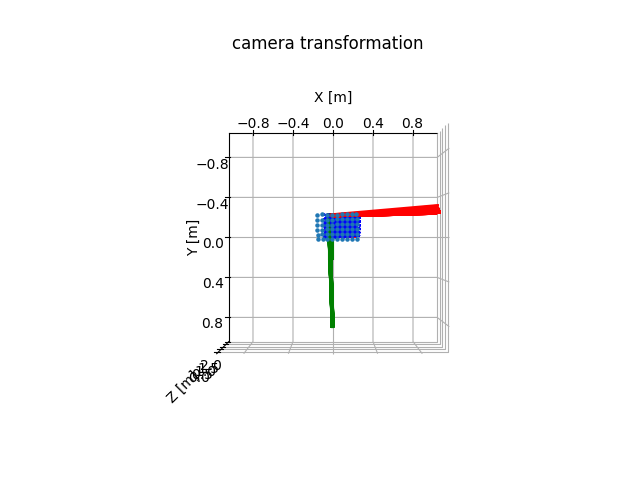

In [41]:
# Transformed Left Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_chest_rgb_left_eye']:
    T = np.matmul(T_chest_cam_ctr, T)  # T_ol = T_oc x T_cl
    T = np.matmul(T, T_gaze_ctr_left)  # T_ol' = T_ol x T_ll'
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

(-0.2, 2.0)

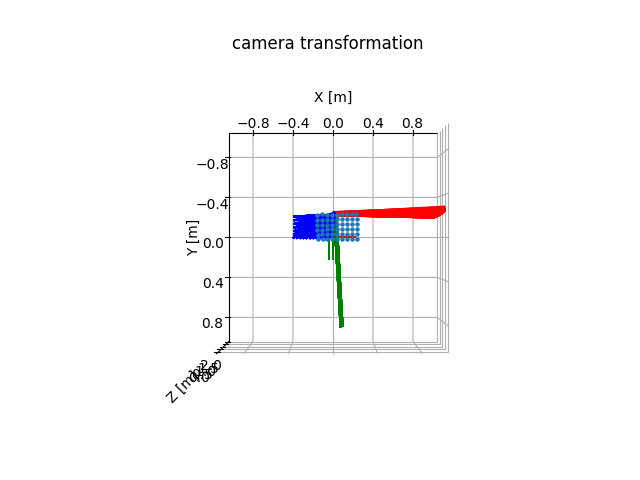

In [42]:
# Transformed Right Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_chest_rgb_right_eye']:
    T = np.matmul(T_chest_cam_ctr, T)  # T_or = T_oc x T_cr
    T = np.matmul(T, T_gaze_ctr_right)  # T_or' = T_or x T_rr'
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

(-0.2, 2.0)

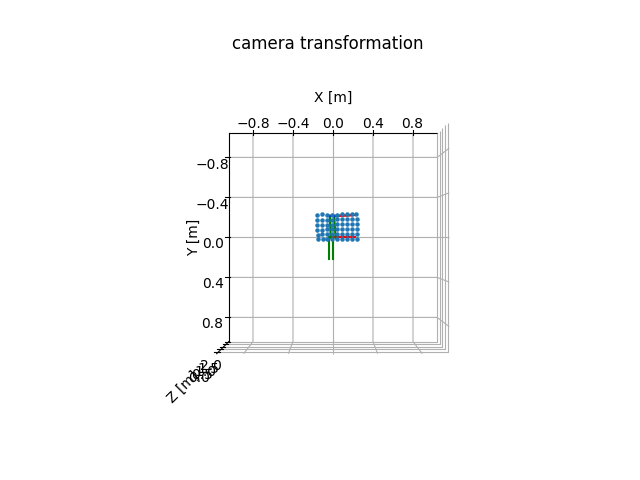

In [43]:
# Transformed Total Plot

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left 0 Pose
T_left = np.matmul(T_chest_cam_ctr, left_zero_T)  # T_ol = T_oc x T_cl_0
T_left = np.matmul(T_left, T_gaze_ctr_left)  # T_ol' = T_ol x T_ll'
ax = pr.plot_basis(ax, T_left[:3,:3], T_left[:3,-1], s=0.2)

# Plot Right 0 Pose
T_right = np.matmul(T_chest_cam_ctr, right_zero_T)  # T_or = T_oc x T_cr_0
T_right = np.matmul(T_right, T_gaze_ctr_right)  # T_or' = T_or x T_rr'
ax = pr.plot_basis(ax, T_right[:3,:3], T_right[:3,-1], s=0.2)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

# Slope/Gain Calculation

## Left Eye

In [44]:
# Rotation

pitch_list = []
yaw_list = []
roll_list = []
for i in range(len(filt_df)):
    rmat = filt_df['T_chest_rgb_left_eye'][i][:3,:3]
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    pitch_list.append(angles[0])
    yaw_list.append(angles[1])
    roll_list.append(angles[2])
filt_df['left_pitch'] = pitch_list
filt_df['left_yaw'] = yaw_list
filt_df['left_roll'] = roll_list

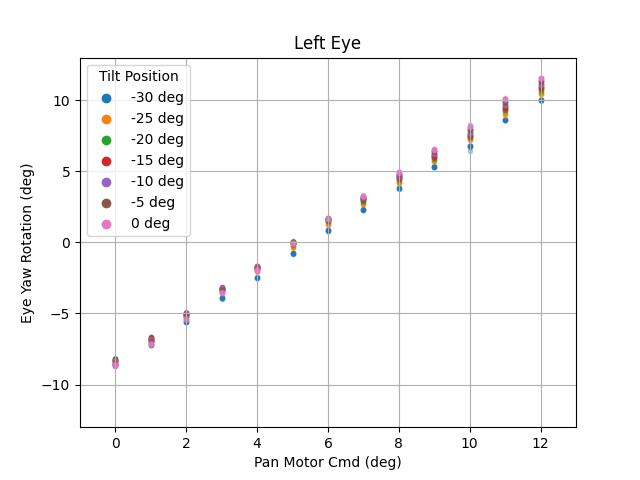

In [45]:
# Pan Slope Plot

plt.figure()

tilt_cmd_list = list(range(-30, 1, 5))
for i in range(len(tilt_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_tilt_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    plt.scatter(df['theta_left_pan_cmd_tminus1'], df['left_yaw'], alpha=0.3, marker='.', color=colors[i])

# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Pan Motor Cmd (deg)')
plt.ylabel('Eye Yaw Rotation (deg)')
plt.xlim([-1, 13])
plt.ylim([-13, 13])
plt.grid()
plt.title('Left Eye')
plt.legend(['-30 deg', '-25 deg', '-20 deg', '-15 deg', '-10 deg', '-5 deg', '0 deg'], title='Tilt Position')

In [46]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_tilt_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    X = df['theta_left_pan_cmd_tminus1'].values.reshape(-1,1)
    y = df['left_yaw'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [1.5575119796390258, 1.5678403233828246, 1.5756440128850413, 1.5936250351077348, 1.620154641236716, 1.658968649702638, 1.696129959168526]
Intercept List: [-8.64621575236616, -8.286482292370724, -8.125836993566356, -8.146001173682302, -8.260251355342927, -8.462261333365955, -8.672918798538413]


Text(0, 0.5, 'm_lpan (yaw/cmd)')

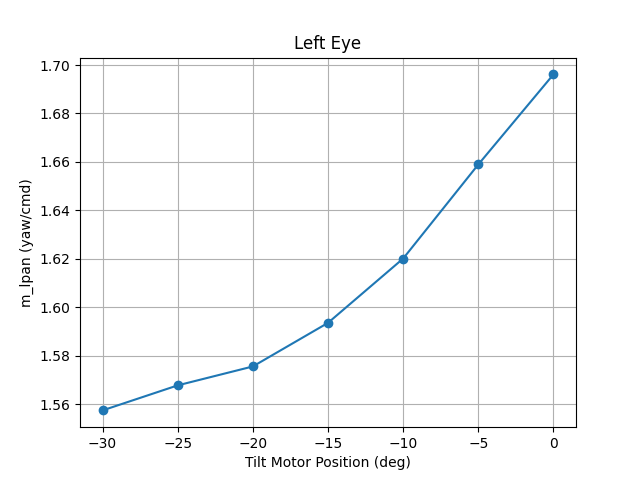

In [47]:
# Slope Plot

plt.figure()
plt.plot(tilt_cmd_list, coef_list, marker='o')
plt.title('Left Eye')
plt.grid()
plt.xlabel('Tilt Motor Position (deg)')
plt.ylabel('m_lpan (yaw/cmd)')

In [48]:
# Mean Left Eye Pan Slope

mean_left_eye_pan_slope = np.mean(coef_list)
print('Mean Left Eye Pan Slope:', mean_left_eye_pan_slope)

Mean Left Eye Pan Slope: 1.6099820858746436


## Right Eye

In [49]:
# Rotation

pitch_list = []
yaw_list = []
roll_list = []
for i in range(len(filt_df)):
    rmat = filt_df['T_chest_rgb_right_eye'][i][:3,:3]
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    pitch_list.append(angles[0])
    yaw_list.append(angles[1])
    roll_list.append(angles[2])
filt_df['right_pitch'] = pitch_list
filt_df['right_yaw'] = yaw_list
filt_df['right_roll'] = roll_list

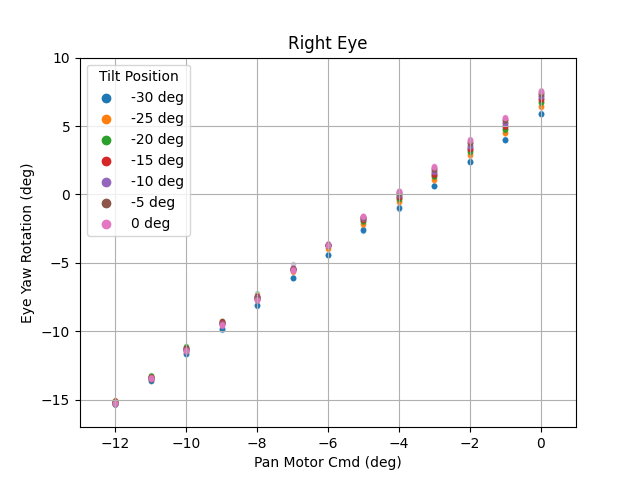

In [50]:
# Pan Slope

plt.figure()

tilt_cmd_list = list(range(-30, 1, 5))
for i in range(len(tilt_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_tilt_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    plt.scatter(df['theta_right_pan_cmd_tminus1'], df['right_yaw'], alpha=0.3, marker='.', color=colors[i])

# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Pan Motor Cmd (deg)')
plt.ylabel('Eye Yaw Rotation (deg)')
plt.xlim([-13, 1])
plt.ylim([-17, 10])
plt.grid()
plt.title('Right Eye')
plt.legend(['-30 deg', '-25 deg', '-20 deg', '-15 deg', '-10 deg', '-5 deg', '0 deg'], title='Tilt Position')

In [51]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(tilt_cmd_list)):
    df = filt_df[filt_df['theta_tilt_cmd_tminus1']==tilt_cmd_list[i]].reset_index()
    X = df['theta_right_pan_cmd_tminus1'].values.reshape(-1,1)
    y = df['right_yaw'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [1.7596499181698453, 1.7850949049414635, 1.8034241627924892, 1.8323129661045687, 1.863405483372469, 1.8930515472364904, 1.9112482277247833]
Intercept List: [5.969544877074588, 6.560363697414201, 6.8589006438009985, 7.093752250923583, 7.324318769691872, 7.55661016678592, 7.719633967873575]


Text(0, 0.5, 'm_rpan (yaw/cmd)')

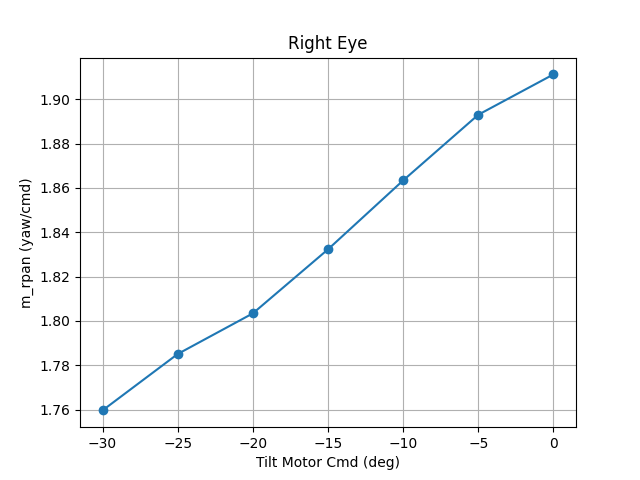

In [52]:
# Slope Plot

plt.figure()
plt.plot(tilt_cmd_list, coef_list, marker='o')
plt.title('Right Eye')
plt.grid()
plt.xlabel('Tilt Motor Cmd (deg)')
plt.ylabel('m_rpan (yaw/cmd)')

In [53]:
# Mean Right Eye Pan Slope

mean_right_eye_pan_slope = np.mean(coef_list)
print('Mean Right Eye Pan Slope:', mean_right_eye_pan_slope)

Mean Right Eye Pan Slope: 1.8354553157631586


## Tilt Slope Left

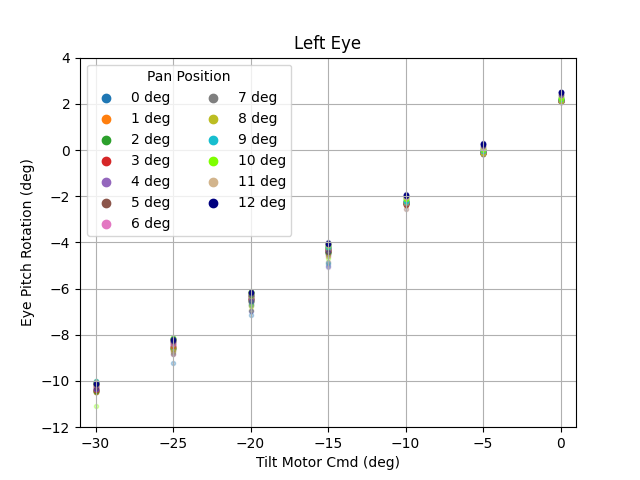

In [54]:
# Tilt Slope Left

plt.figure()

left_pan_cmd_list = list(range(0, 13))
for i in range(len(left_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_left_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_tilt_cmd_tminus1'], df['left_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Tilt Motor Cmd (deg)')
plt.ylabel('Eye Pitch Rotation (deg)')
plt.xlim([-31, 1])
plt.ylim([-12, 4])
plt.title('Left Eye')
plt.legend(['0 deg', '1 deg', '2 deg', '3 deg', '4 deg', '5 deg', '6 deg',
           '7 deg', '8 deg', '9 deg', '10 deg', '11 deg', '12 deg'], title='Pan Position', ncol=2)
plt.grid()

In [55]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(left_pan_cmd_list)):
    df = filt_df[filt_df['theta_left_pan_cmd_tminus1']==left_pan_cmd_list[i]].reset_index()
    X = df['theta_tilt_cmd_tminus1'].values.reshape(-1,1)
    y = df['left_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.4235259319385442, 0.4220261260242206, 0.42008223196618527, 0.4170627043758063, 0.41755714332535293, 0.411968406166279, 0.40862787864136274, 0.4059747506789591, 0.4077842309672524, 0.40902910054237573, 0.41435636800293346, 0.4176385062313726, 0.42304945550361334]
Intercept List: [1.9900707222872986, 2.0038385126020204, 1.987487770101426, 1.9811649685755164, 1.99557642707587, 1.946561523344407, 1.9467812757654697, 1.9330369465956165, 1.9651810013629998, 2.029657736596471, 2.132148942098014, 2.237561144433449, 2.3511802642625415]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

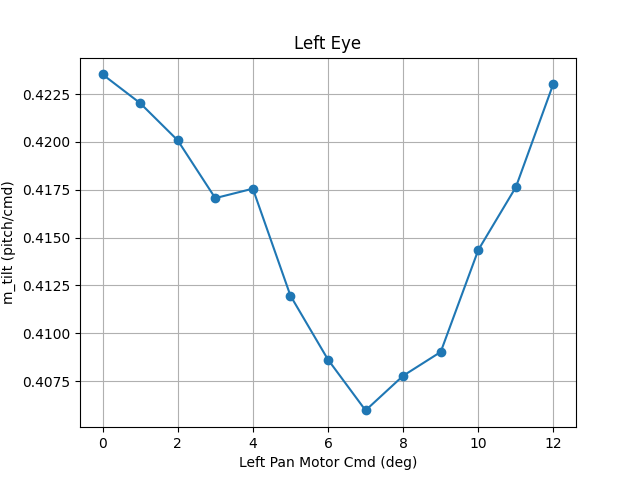

In [56]:
# Slope Plot

plt.figure()
plt.plot(left_pan_cmd_list, coef_list, marker='o')
plt.title('Left Eye')
plt.grid()
plt.xlabel('Left Pan Motor Cmd (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [57]:
# Mean Left Eye Tilt Slope

mean_left_eye_tilt_slope = np.mean(coef_list)
print('Mean Left Eye Tilt Slope:', mean_left_eye_tilt_slope)

Mean Left Eye Tilt Slope: 0.41528329495109684


## Tilt Slope Right

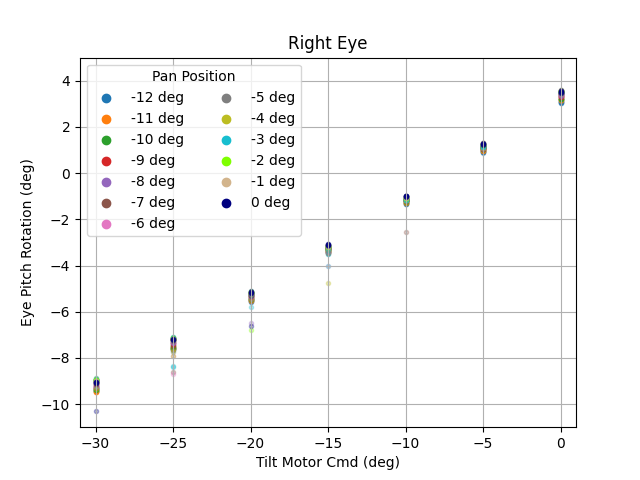

In [58]:
# Tilt Slope Right

plt.figure()

right_pan_cmd_list = list(range(-12, 1))
for i in range(len(right_pan_cmd_list)):
    plt.scatter(-100,-100, color=colors[i])

for i in range(len(right_pan_cmd_list)):
    df = filt_df[filt_df['theta_right_pan_cmd_tminus1']==right_pan_cmd_list[i]].reset_index()
    plt.scatter(df['theta_tilt_cmd_tminus1'], df['right_pitch'], alpha=0.3, marker='.', color=colors[i])
    
# plt.legend(['roll', 'pitch', 'yaw'])  # Rotation across z, y, x [but currently in opencv coordinates]
plt.xlabel('Tilt Motor Cmd (deg)')
plt.ylabel('Eye Pitch Rotation (deg)')
plt.xlim([-31, 1])
plt.ylim([-11, 5])
plt.title('Right Eye')
plt.legend(['-12 deg', '-11 deg', '-10 deg', '-9 deg', '-8 deg', '-7 deg', '-6 deg',
           '-5 deg', '-4 deg', '-3 deg', '-2 deg', '-1 deg', '0 deg'], title='Pan Position', ncol=2)
plt.grid()

In [59]:
# Slope Calculation

score_list = []
coef_list = []
intercept_list = []
for i in range(len(right_pan_cmd_list)):
    df = filt_df[filt_df['theta_right_pan_cmd_tminus1']==right_pan_cmd_list[i]].reset_index()
    X = df['theta_tilt_cmd_tminus1'].values.reshape(-1,1)
    y = df['right_pitch'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    score_list.append(reg.score(X, y).item())
    coef_list.append(reg.coef_.squeeze().item())
    intercept_list.append(reg.intercept_.item())
    
print('Coef List:', coef_list)
print('Intercept List:', intercept_list)

Coef List: [0.42029680530932295, 0.4239193804970556, 0.42308789362121707, 0.421372962542522, 0.4226243546872151, 0.42030324804887326, 0.4191293225163452, 0.4164826816010712, 0.41982745565511614, 0.41967208319134197, 0.42013522970420075, 0.42056582841858886, 0.42518544313709455]
Intercept List: [2.96992673854613, 3.0649994827228264, 3.127768666755861, 3.174639689521122, 3.2157430574185915, 3.2017767737941294, 3.2238386262094023, 3.2092561971105162, 3.2445132936865773, 3.2512765531370245, 3.3058663256142293, 3.3383646576316464, 3.369724751909251]


Text(0, 0.5, 'm_tilt (pitch/cmd)')

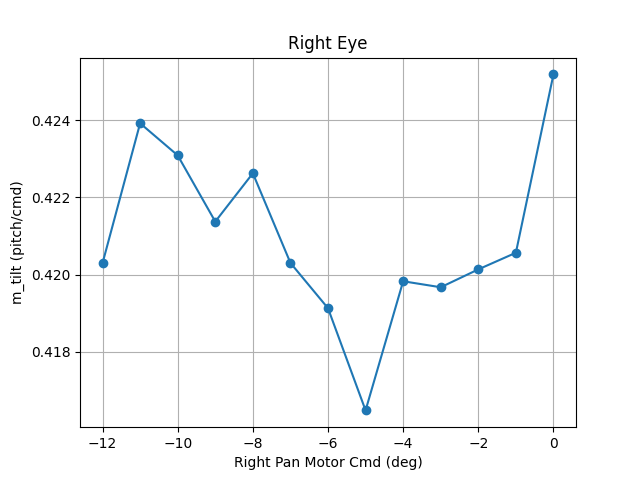

In [60]:
# Slope Plot

plt.figure()
plt.plot(right_pan_cmd_list, coef_list, marker='o')
plt.title('Right Eye')
plt.grid()
plt.xlabel('Right Pan Motor Cmd (deg)')
plt.ylabel('m_tilt (pitch/cmd)')
#plt.ylim([0,1])

In [61]:
# Mean Left Eye Tilt Slope

mean_right_eye_tilt_slope = np.mean(coef_list)
print('Mean Right Eye Tilt Slope:', mean_right_eye_tilt_slope)

Mean Right Eye Tilt Slope: 0.4209694376099973


## Average Tilt

In [62]:
# Average Tilt

mean_tilt_eye_slope = (mean_left_eye_tilt_slope + mean_right_eye_tilt_slope)/2
print('Mean Tilt Eyes Slope:', mean_tilt_eye_slope)

Mean Tilt Eyes Slope: 0.41812636628054706


# Saving Parameters

In [63]:
# Display Old Calibration Params

calib_params

{'left_eye': {'slope': 1.6099820858746436,
  'backlash': 3.3891,
  'x_center': 360.6,
  'y_center': 224.7},
 'right_eye': {'slope': 1.8354553157631586,
  'backlash': 2.162,
  'x_center': 222.3,
  'y_center': 235.9},
 'tilt_eyes': {'slope': 0.41812636628054706, 'backlash': 0},
 'transformations': {'T_origin_chest': [[1.0, 0.0, 0.0, -0.0325],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_left_eye': [[0.9880472250223036,
    0.03092441965992675,
    -0.15101661889387422,
    0.003950221340934867],
   [-0.036089393248781895,
    0.9988493170197064,
    -0.031581432792167914,
    -0.19488571945212643],
   [0.14986619094848266,
    0.03665401806508005,
    0.9880263805311275,
    0.008113693706282144],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_right_eye': [[0.9898947487554116,
    0.062060615849186415,
    0.1275003424867875,
    0.04408937533403663],
   [-0.05362870751047605,
    0.9962060635183969,
    -0.06853558437278509,
    -0.1921703254550676],
   [

In [64]:
# Storing in New Calibration Parameters

new_calib_params = copy.deepcopy(calib_params)
new_calib_params['left_eye']['slope'] = mean_left_eye_pan_slope
new_calib_params['right_eye']['slope'] = mean_right_eye_pan_slope
new_calib_params['tilt_eyes']['slope'] = mean_tilt_eye_slope
new_calib_params['transformations']['T_origin_chest'] = T_chest_cam_ctr.tolist()
new_calib_params['transformations']['T_chest_left_eye'] = left_zero_T.tolist()
new_calib_params['transformations']['T_chest_right_eye'] = right_zero_T.tolist()
new_calib_params['transformations']['T_left_eye_gaze_ctr'] = T_gaze_ctr_left.tolist()
new_calib_params['transformations']['T_right_eye_gaze_ctr'] = T_gaze_ctr_right.tolist()
new_calib_params

{'left_eye': {'slope': 1.6099820858746436,
  'backlash': 3.3891,
  'x_center': 360.6,
  'y_center': 224.7},
 'right_eye': {'slope': 1.8354553157631586,
  'backlash': 2.162,
  'x_center': 222.3,
  'y_center': 235.9},
 'tilt_eyes': {'slope': 0.41812636628054706, 'backlash': 0},
 'transformations': {'T_origin_chest': [[1.0, 0.0, 0.0, -0.0325],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_left_eye': [[0.9880472250223036,
    0.03092441965992675,
    -0.15101661889387422,
    0.003950221340934867],
   [-0.036089393248781895,
    0.9988493170197064,
    -0.031581432792167914,
    -0.19488571945212643],
   [0.14986619094848266,
    0.03665401806508005,
    0.9880263805311275,
    0.008113693706282144],
   [0.0, 0.0, 0.0, 1.0]],
  'T_chest_right_eye': [[0.9898947487554116,
    0.062060615849186415,
    0.1275003424867875,
    0.04408937533403663],
   [-0.05362870751047605,
    0.9962060635183969,
    -0.06853558437278509,
    -0.1921703254550676],
   [

In [65]:
# Saving New Json File

current_dir = os.getcwd()
dt_str = datetime.now().strftime("%Y%m%d")[2:]
filename = os.path.join(current_dir, 'config', 'calib', 'calib_params_'+dt_str+'.json')

with open(filename, "w") as outfile:
    json.dump(new_calib_params, outfile)
    print('Saving new calibration file at:', filename)

Saving new calibration file at: /home/jaynieles/dev/grace_robot/config/calib/calib_params_240416.json
